In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV 
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import seaborn as sns

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.probability import FreqDist

from nltk.sentiment.vader import SentimentIntensityAnalyzer

## En aquesta tasca, i a partir d'ara endavant, usaré nomenclatura anglesa enlloc de la catalana habitaul tal i com recomanes en aula virtual

In [2]:
heart_attacks = pd.read_csv('H:\_vertex\_formacio\_python - cibernarium\_16\_16_05\_dataset\heart.csv')
heart_attacks.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
# Dimensions, info about nulls values & description/statistics of dataset
display(heart_attacks.shape)
display(heart_attacks.info())
display(heart_attacks.describe())

(303, 14)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


None

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [4]:
# 'output' column labels dataset in a binary way: '1' for heart attack and '0' for non heart attack
heart_attacks.output.value_counts()

1    165
0    138
Name: output, dtype: int64

In [5]:
# Dataset seams balanced in this way, but for sure will do a SMOTE

<AxesSubplot:>

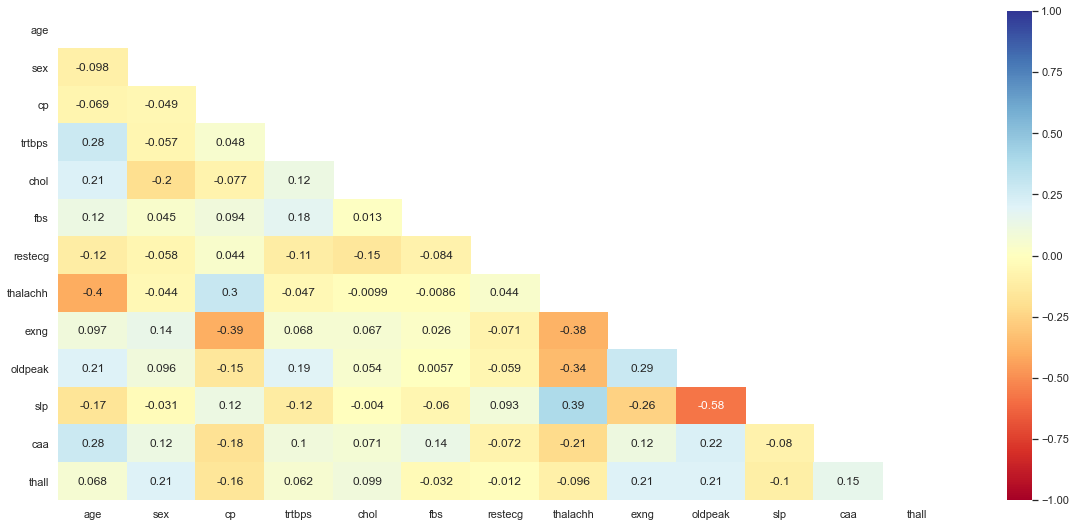

In [6]:
# Observamos que existe muy poca correlación entre los atributos del dataset. Siguiendo la sugerencia de mejora recibidos en la
# tasca anterior, he dibujado sólo el 'lower triangle' para evitar la repetición ;)

sns.set_theme(style="white")
heart_attacks_corr = heart_attacks.drop(['output'], axis = 1).corr()
mask = np.triu(heart_attacks_corr)
fig, ax = plt.subplots(figsize = [20, 9])

sns.heatmap(heart_attacks_corr, annot = True, vmin = -1, vmax = 1, center = 0, cmap="RdYlBu", mask= mask, cbar_kws={"shrink": 1})

C:\Users\Antoni\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Antoni\anaconda3\lib\site-packages\seaborn\_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
C:\Users\Antoni\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Antoni\anaconda3\lib\site-packages\seaborn\_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_v

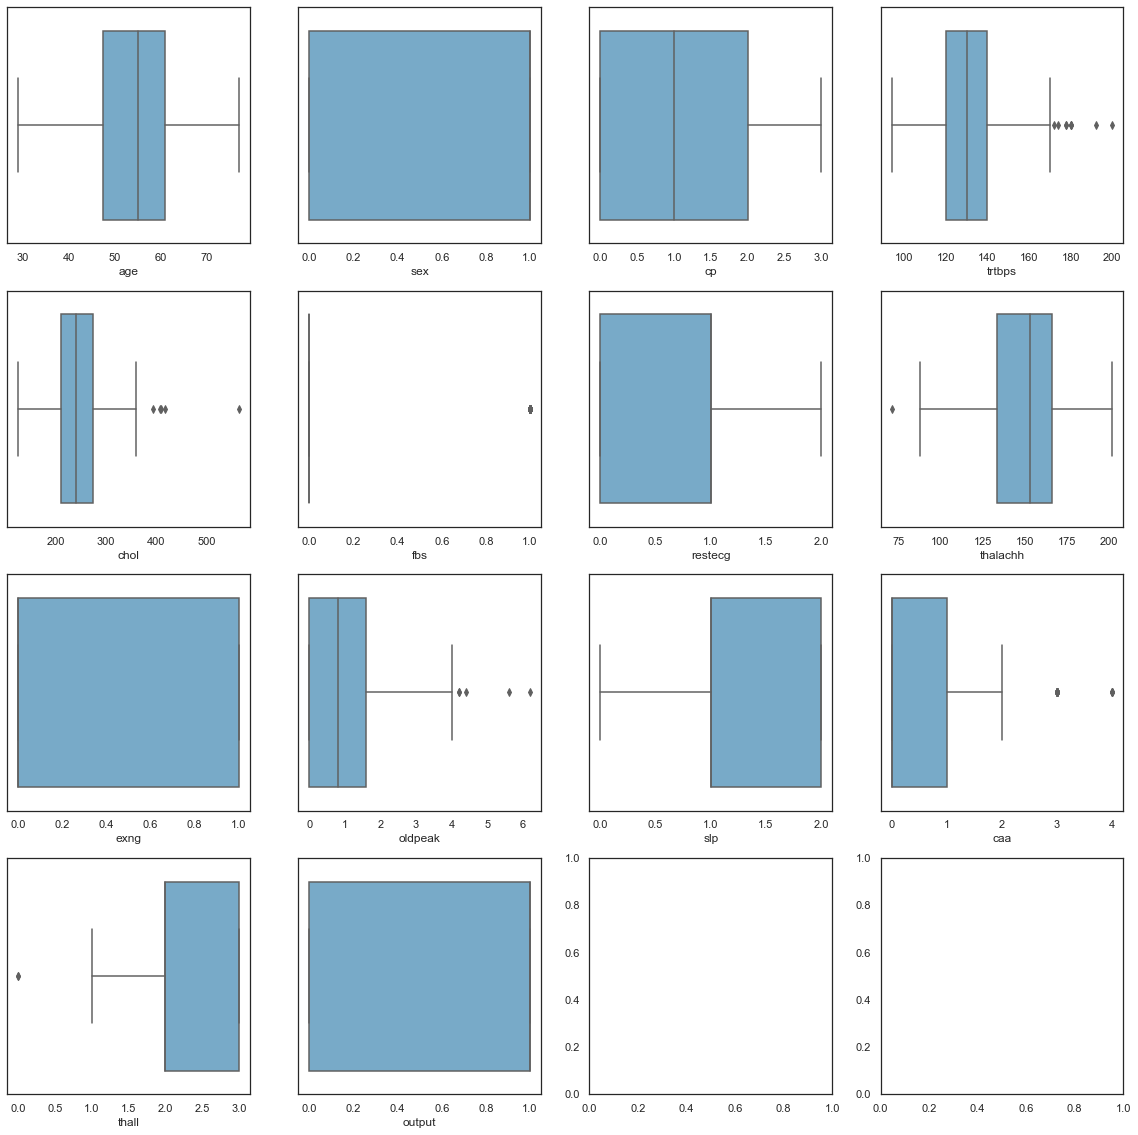

In [7]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=[20, 20])
for column, ax in zip(list(heart_attacks.columns), ax.flatten()):
  sns.boxplot(heart_attacks[column], ax=ax, orient='v', palette="Blues")
  #ax.set_title(column)

## Nivell 1

- Exercici 1

    Agafa el conjunt de dades que vulguis i realitza un pipeline i un gridsearch aplicant l'algorisme de Random Forest.

In [8]:
# Explicative columns, 'X', and column to predict 'y'
X = heart_attacks.drop(['output'], axis = 1)
y = heart_attacks['output']

# X columns list
X_columns_list = list(X.columns)
print(X_columns_list)

['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh', 'exng', 'oldpeak', 'slp', 'caa', 'thall']


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 54321)
print('Train dataset dimensions: {}\nTest dataset dimensions:  {}'.format(X_train.shape, X_test.shape))

Train dataset dimensions: (242, 13)
Test dataset dimensions:  (61, 13)


In [10]:
# Pipeline steps definition
# a. Standarize columns
# b. SMOTE
# c. Random Forest trainnig

heart_attacks_RF_pipeline = Pipeline([('standarize',StandardScaler()),
                                      ('smote', SMOTE(n_jobs=-1, random_state=3)),
                                      ('random_forest', RandomForestClassifier(random_state=3))])

In [11]:
# Selection of parameters and its values
heart_attacks_RF_tuned_parameters = {'random_forest__n_estimators': [65,125,175],
                    'random_forest__criterion': ['gini','entropy'],
                    'random_forest__max_features': ['auto', 'sqrt', 'log2'],}

# Metrics to optimize
score='f1'

# Tune parameters
heart_attacks_RF_tuned_parameters_grid_search = GridSearchCV(estimator = heart_attacks_RF_pipeline, param_grid = heart_attacks_RF_tuned_parameters, cv=10, scoring='%s' % score, n_jobs= -1)
heart_attacks_RF_tuned_parameters_grid_search.fit(X_train, y_train)
    
print('Best parameters:\n{}'.format(heart_attacks_RF_tuned_parameters_grid_search.best_params_))

Best parameters:
{'random_forest__criterion': 'entropy', 'random_forest__max_features': 'auto', 'random_forest__n_estimators': 175}


In [12]:
heart_attacks_RF_tuned_parameters_grid_search_test_prediction = heart_attacks_RF_tuned_parameters_grid_search.predict(X_test)

print(metrics.classification_report(                       y_test, heart_attacks_RF_tuned_parameters_grid_search_test_prediction))
print("Accuracy score:   ", round(metrics.accuracy_score(  y_test, heart_attacks_RF_tuned_parameters_grid_search_test_prediction),4))
print("AUC:              ", round(metrics.roc_auc_score(   y_test, heart_attacks_RF_tuned_parameters_grid_search_test_prediction),4))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79        22
           1       0.88      0.90      0.89        39

    accuracy                           0.85        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.85      0.85      0.85        61

Accuracy score:    0.8525
AUC:               0.8351


- Exercici 2

    Agafa un text en anglès que vulguis, i calcula'n la freqüència de les paraules.

In [13]:
# Text from a Cosmology blog
# https://cupofcosmology.blogspot.com/

text = """

The Big Bang Model

The Big Bang Theory is one of the pillars of modern cosmology, so it's about time I dedicated a blog post to it. The Big Bang (BB for short) is many things, but before we get into that, it's useful to first remember what it isn't.

What it isn't
A TV series. There is no laugh track included in this blog post, I'm afraid.
On a slightly more serious note, one of the most common misconceptions about the BB is that it's a theory about the origin of the universe. The BB model is often accused of "not explaining what caused the bang, or what came before the bang", but the Big Bang theory never claimed to be able to explain these things; that's not its purpose. That's like asking a coffee machine to make you toast. If you do want toast (or an answer to the question of what came before the Big Bang), you might find something useful on the FAQ post. No toast here though, only coffee.
Another misconception about the BB model is the "bang" part. Despite the misleading name, the Big Bang model does not involve an actual bang; there was no initial explosion, but there was - and still is - an expansion taking place everywhere in the universe at the same time.

Okay, so what is it?
13.8 billion years of history in one image.
The BB theory explains the evolution of the universe from an initial singularity until today, and makes predictions for what we can expect in the future. That means the BB model covers more than 13.82 billion years of cosmic expansion, which is rather impressive. In very early times, the universe was in a really hot, really dense, and really small state. We refer to this as the initial singularity, or "Big Bang". The theory doesn't start at this singularity, though, as a singularity is just a fancy way of saying "our equations break down at this point". Our model begins a fraction of a second after this initial singularity, and moves forward with it. The BB theory explains that the universe has been gradually expanding and cooling down, going from this hot, dense, and small initial state to the massive, complex, and rather chilly place that it is today.

This cooling down and expansion is a lot more significant than it might sound, though. As the universe cooled down, the first particles could begin to form. Initially, the universe was so hot that everything was a bit chaotic: the particles were constantly interacting, but not forming lasting bonds. Dark matter particles, always the more elusive of the bunch, broke away at an early time and went their separate way to start setting up the scaffolding for future structures.
Gradually, the temperature cooled down enough for "normal" (baryonic matter) particles to bind together and form the first nuclei. First came hydrogen nuclei, and through Big Bang Nucleosynthesis - which is very similar to what happens inside stars - heavier nuclei like Helium and Lithium could form. With more expansion and cooling down, electrons could combine with the nuclei to form the first atoms - which also caused the photons (particles of light) to break away, to later become the cosmic microwave background radiation.
Filaments of dark matter on large scales, with galaxy clusters
at the intersections. From Springel et al, Millennium Simulation
These initial hydrogen atoms could coalesce into the first stars, and with enough stars in one place, the first galaxies could begin to form, and later galaxy clusters. But these galaxies didn't just form anywhere; the dark matter that broke away at an earlier time had a strong gravitational effect, causing the stars and galaxies to form in a giant structure we call "cosmic web". All of this could happen thanks to the expansion and cooling of the universe, and all of this is described by the Big Bang theory.

Why should I believe it?
As any good scientific theory, the Big Bang model has a lot of observational evidence backing it up. The expansion of the universe was first measured by Hubble in the early 20th century. Hubble noticed that distant galaxies move away from us faster than closer galaxies. Since then, we have increasingly precise measurements of the movement of galaxies, which all seem to indicate an expanding universe. We've also been able to measure that this expansion is accelerating, but that's a whole other blog post.
Furthermore, the abundance of the light elements (like Lithium and Helium) should be set by the Big Bang Nucleosynthesis, and can be calculated. We can measure the amount of these light elements in really distant galaxies in early stages of evolution, where there hasn't been enough time for more of these elements to form. The results of these measurement match what we expect from the BB model.

But a theory is not complete without predictions. The biggest prediction made by the Big Bang model is the the Cosmic Microwave Background radiation (CMB), which is a bath of photons everywhere in the universe, made up of the photons that broke away when the first atoms were formed. These photons have been propagating freely ever since, growing fainter and less energetic due to the expansion of space (if their wavelength increases over time, their energy decreases). The accidental discovery of the CMB in 1964 by Penzias and Wilson, which led to a Nobel Prize in 1964, was the key piece of evidence which made the Big Bang model the prevailing cosmological theory.

Not perfect, but the best we have
With all the evidence we have, we know that the Big Bang theory is the best model we currently have to understand the universe. However, despite its overwhelming success, there are a few aspects of the universe that seem at odds with the Big Bang Model.

    Horizon problem: The photons of the CMB have the same average temperature of 2.73 Kelvin (-270 Celsius), varying by no more than one part in 10000. This means that if we measure CMB photons coming from opposite directions, they will be at the same temperature, despite being separated by more than 28 billion light years. As nothing can travel faster than the speed of light, these photons have not been able to communicate in any way, and given how far apart they are now, they weren't in causal contact (close enough to affect each other) in the early universe. This poses the question of why are all of the photons at the same temperature? 
    Flatness problem: We have very good measurements on the shape of the observable universe, and our latest data show us that the universe is flat (if you are wondering what we mean by a flat universe, check out question 18 in the FAQ page). The shape of the observable universe is given by its density, and this could take any value, yet of all the possible values, the density is exactly the one that is needed to have a flat universe. This seems like a fine-tuning issue, and rises the question of why is the universe so flat?
    Monopole problem: Electricity and magnetism present a certain duality, and can in fact be grouped together under the umbrella term "electromagnetism". We have single electric poles -or charges - in the form of electrons. However, no single magnetic charge - or monopole - has ever been found, despite being predicted by several particle physics models. Of course, it could be that the models predicting these magnetic monopoles are wrong, but it is also interesting to wonder if there is a deeper explanation to why we haven't yet found these monopoles. 


Given these questions, what do we do with the Big Bang model? Unanswered questions are usually not a good thing in scientific theories. But don't worry, the Big Bang theory is safe: we know how to solve these issues! We just need to introduce something known as inflation, which will be the focus of a future blog post.
"""

In [14]:
# Text segmented
# nltk.download('punkt')
text_tokenized = word_tokenize(text)

In [15]:
# Unique and total words in text
text_tokenized_frequency_distribution = FreqDist(text_tokenized)
print(text_tokenized_frequency_distribution)

<FreqDist with 506 samples and 1537 outcomes>


In [16]:
# Most common words
text_tokenized_frequency_distribution.most_common(5)

[('the', 97), (',', 80), ('.', 55), ('of', 43), ('to', 31)]

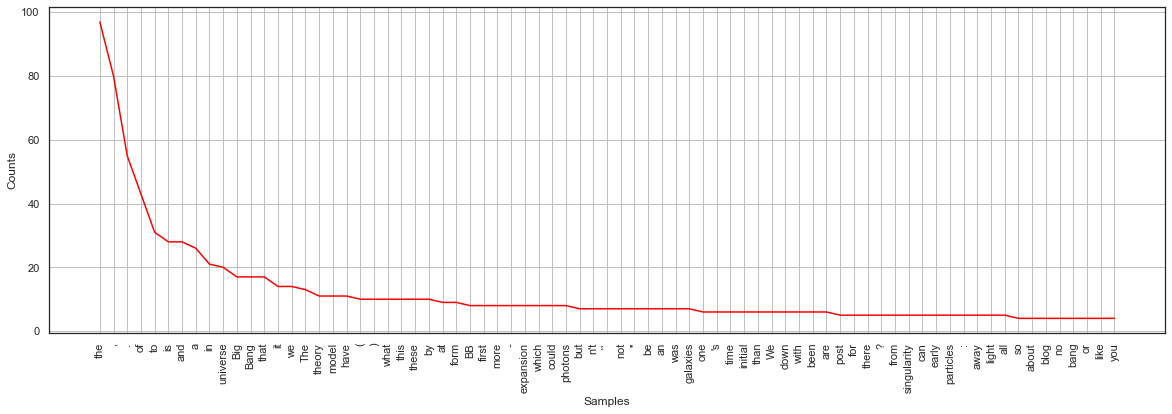

In [17]:
# Plotting words frequency distribution
plt.figure(figsize=(20,6))
text_tokenized_frequency_distribution.plot(75,cumulative=False, linewidth=1.5, label='Theoretical', color = 'red')
plt.show()

## Nivell 2

- Exercici 1

    Treu les stopwords i realitza stemming al teu conjunt de dades.

In [18]:
# Stop words list
# nltk.download('stopwords')
text_tokenized_stop_words = set(stopwords.words("english"))
print(text_tokenized_stop_words)

{'of', 'my', "it's", 'we', 'before', 'doing', 'now', 'who', 'which', 'on', "should've", 'themselves', 'd', 'yourself', 'does', 'once', 'there', "that'll", 'same', "hasn't", "shan't", 'wasn', 'and', 'for', 'were', 'ain', 'o', 'where', 't', 'you', 'most', 'any', 'herself', "you're", 'own', 'just', 'won', 'your', 'are', 'doesn', 'been', 'at', 'haven', 'under', 'but', "needn't", 'or', 'mustn', 'be', 'here', "wasn't", 'they', "weren't", 'why', 'few', 'all', 'not', 'than', 'ours', "you've", 'into', 'hasn', 'theirs', "hadn't", 'has', 'will', 's', 'them', 'out', "mightn't", 'an', "don't", 'am', 'other', 'it', 'is', 'that', 'while', 'his', 'me', 'then', 'ma', 'did', 'll', 'against', "aren't", 'very', 'off', 'above', 'how', 've', "shouldn't", 'again', 'was', 'him', 'having', 'nor', 'aren', 'no', 'between', 're', 'through', 'because', "she's", 'whom', 'mightn', 'this', 'some', 'up', "mustn't", 'needn', 'those', 'after', 'have', 'each', 'yours', "isn't", 'further', 'hers', 'over', 'y', 'ourselves'

In [19]:
# Delete stop words in text
text_tokenized_without_stop_words = []
for word in text_tokenized:
    if word not in text_tokenized_stop_words:
        text_tokenized_without_stop_words.append(word)
        
print(text_tokenized_without_stop_words)

['The', 'Big', 'Bang', 'Model', 'The', 'Big', 'Bang', 'Theory', 'one', 'pillars', 'modern', 'cosmology', ',', "'s", 'time', 'I', 'dedicated', 'blog', 'post', '.', 'The', 'Big', 'Bang', '(', 'BB', 'short', ')', 'many', 'things', ',', 'get', ',', "'s", 'useful', 'first', 'remember', "n't", '.', 'What', 'A', 'TV', 'series', '.', 'There', 'laugh', 'track', 'included', 'blog', 'post', ',', 'I', "'m", 'afraid', '.', 'On', 'slightly', 'serious', 'note', ',', 'one', 'common', 'misconceptions', 'BB', "'s", 'theory', 'origin', 'universe', '.', 'The', 'BB', 'model', 'often', 'accused', '``', 'explaining', 'caused', 'bang', ',', 'came', 'bang', "''", ',', 'Big', 'Bang', 'theory', 'never', 'claimed', 'able', 'explain', 'things', ';', "'s", 'purpose', '.', 'That', "'s", 'like', 'asking', 'coffee', 'machine', 'make', 'toast', '.', 'If', 'want', 'toast', '(', 'answer', 'question', 'came', 'Big', 'Bang', ')', ',', 'might', 'find', 'something', 'useful', 'FAQ', 'post', '.', 'No', 'toast', 'though', ',',

In [20]:
# Aplicació del Stemming
porterstemmer = PorterStemmer()

text_tokenized_stemmed_words=[]
for word in text_tokenized_without_stop_words:
    text_tokenized_stemmed_words.append(porterstemmer.stem(word))

print('Filtered --> Stemmed:\n====================')    
for word in range(0,len(text_tokenized_stemmed_words)):
    print('{} --> {}'.format(text_tokenized_without_stop_words[word],text_tokenized_stemmed_words[word]))

Filtered --> Stemmed:
The --> the
Big --> big
Bang --> bang
Model --> model
The --> the
Big --> big
Bang --> bang
Theory --> theori
one --> one
pillars --> pillar
modern --> modern
cosmology --> cosmolog
, --> ,
's --> 's
time --> time
I --> I
dedicated --> dedic
blog --> blog
post --> post
. --> .
The --> the
Big --> big
Bang --> bang
( --> (
BB --> BB
short --> short
) --> )
many --> mani
things --> thing
, --> ,
get --> get
, --> ,
's --> 's
useful --> use
first --> first
remember --> rememb
n't --> n't
. --> .
What --> what
A --> A
TV --> TV
series --> seri
. --> .
There --> there
laugh --> laugh
track --> track
included --> includ
blog --> blog
post --> post
, --> ,
I --> I
'm --> 'm
afraid --> afraid
. --> .
On --> On
slightly --> slightli
serious --> seriou
note --> note
, --> ,
one --> one
common --> common
misconceptions --> misconcept
BB --> BB
's --> 's
theory --> theori
origin --> origin
universe --> univers
. --> .
The --> the
BB --> BB
model --> model
often --> often
accu

## Nivell 3

- Exercici 1

    Realitza sentiment analysis al teu conjunt de dades.

In [21]:
# Convert text to sentences list
text_tokenized_list=sent_tokenize(text)
print(text_tokenized_list)

["\n\nThe Big Bang Model\n\nThe Big Bang Theory is one of the pillars of modern cosmology, so it's about time I dedicated a blog post to it.", "The Big Bang (BB for short) is many things, but before we get into that, it's useful to first remember what it isn't.", "What it isn't\nA TV series.", "There is no laugh track included in this blog post, I'm afraid.", "On a slightly more serious note, one of the most common misconceptions about the BB is that it's a theory about the origin of the universe.", 'The BB model is often accused of "not explaining what caused the bang, or what came before the bang", but the Big Bang theory never claimed to be able to explain these things; that\'s not its purpose.', "That's like asking a coffee machine to make you toast.", 'If you do want toast (or an answer to the question of what came before the Big Bang), you might find something useful on the FAQ post.', 'No toast here though, only coffee.', 'Another misconception about the BB model is the "bang" p

In [22]:
# Convert to dataframe
text_tokenized_list_df = pd.DataFrame(text_tokenized_list)

# View of dataframe, shape and non nulls
display(text_tokenized_list_df.head())
display(text_tokenized_list_df.shape)
display(text_tokenized_list_df.info())

,0
0,\n\nThe Big Bang Model\n\nThe Big Bang Theory ...
1,"The Big Bang (BB for short) is many things, bu..."
2,What it isn't\nA TV series.
3,There is no laugh track included in this blog ...
4,"On a slightly more serious note, one of the mo..."


(61, 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       61 non-null     object
dtypes: object(1)
memory usage: 616.0+ bytes


None

In [23]:
# Labelling sentiment using Vader algortihm
# It's non supervised method based on opinion analysis rules.

sentiment_analyzer = SentimentIntensityAnalyzer()

def vader_algortihm(sentence):
    sentiment_scores = sentiment_analyzer.polarity_scores(sentence)
    if sentiment_scores["neg"] > sentiment_scores["pos"]:
        return 0
    else:
        return 1

In [24]:
# Using Vader algorithm on dataframe
text_tokenized_list_df["sentiment"] = text_tokenized_list_df[0].apply(lambda sentence: vader_algortihm(sentence))

display(text_tokenized_list_df.head())
display(text_tokenized_list_df.shape)


,0,sentiment
0,\n\nThe Big Bang Model\n\nThe Big Bang Theory ...,1
1,"The Big Bang (BB for short) is many things, bu...",1
2,What it isn't\nA TV series.,1
3,There is no laugh track included in this blog ...,1
4,"On a slightly more serious note, one of the mo...",0


(61, 2)

In [25]:
# Value counts of sentiment column
text_tokenized_list_df['sentiment'].value_counts()

1    49
0    12
Name: sentiment, dtype: int64

In [26]:
# Use of Tokenizer to delete not usefull words
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')

# CountVectorizer matrix
count_vectorizer = CountVectorizer(lowercase=True, stop_words='english', ngram_range = (1,1), tokenizer = tokenizer.tokenize)
count_vectorizer_counts = count_vectorizer.fit_transform(text_tokenized_list_df[0].values.astype(str))

display(count_vectorizer_counts)

<61x346 sparse matrix of type '<class 'numpy.int64'>'
	with 610 stored elements in Compressed Sparse Row format>

In [27]:
# Train and test
X_train, X_test, y_train, y_test = train_test_split(count_vectorizer_counts, text_tokenized_list_df['sentiment'], test_size=0.2, random_state=1357)

# Create Multinomial model
multinomial_classification = MultinomialNB().fit(X_train, y_train)
predicted = multinomial_classification.predict(X_test)

# Calculate accuracy
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted).round(4))

MultinomialNB Accuracy: 0.7692
